In [1]:
'''Imports'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
load_path_daily = "./mef-data/daily/"
load_path_seasonal = "./mef-data/seasonal/"
save_path = "./Figures/Paper Figures/"

drainablePorosity = 0.57 #bog porosity

pal = sns.color_palette('winter', 3)

def findLastNonZero(myList):
    persist = 0
    DOD = 0
    myList = myList[0:167]
    for index, value in reversed(list(enumerate(myList))):
        if(value > 0):
            if(persist == 0):
                DOD = index
                persist = 1
            elif((persist < 7) and (persist > 0)):
                persist = persist + 1
            elif(persist == 7):
                return int(DOD)
        elif(value == 0):
            persist = 0
            
    return np.nan

In [3]:
'''Data Import'''
#Precipitation
#Precip is in centimeters
precip = pd.read_csv(load_path_daily + 'MEF_precipitation_daily.csv', 
                    parse_dates = ['DATE'])
precip['YEAR'] = precip.DATE.dt.year
precip['MONTH'] = precip.DATE.dt.month
precip['DOY'] = precip.DATE.dt.dayofyear

#Import Air Temperature
airTemp = pd.read_csv(load_path_daily + 'MEF_airTemp_daily.csv', 
                    parse_dates = ['Date'])
airTemp['YEAR'] = airTemp.Date.dt.year
airTemp['MONTH'] = airTemp.Date.dt.month
airTemp['DOY'] = airTemp.Date.dt.dayofyear
airTemp = airTemp[airTemp.STATION == 'South'].reset_index(drop = True)

#Seasonal Soil Moisture
soilMoist = pd.read_csv(load_path_seasonal + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path_seasonal + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

#Water Table
wteHist = pd.read_csv(load_path_daily + 'MEF_daily_peatland_water_table.csv', 
                parse_dates = ['DATE'])
wte = wteHist[wteHist.PEATLAND == 'S2'].reset_index(drop = True)
wte['YEAR'] = wte.DATE.dt.year

#Streamflow
streamHist = pd.read_csv(load_path_daily + 'Streamflow_daily.csv', 
                parse_dates = ['Date'])
streamHist['YEAR'] = streamHist.Date.dt.year

#Snowdepths 
snowHist = pd.read_csv(load_path_daily + 'GR_ForestryLab_snow_daily.csv', 
                names = ["Date","MaxTemp","MinTemp","P_in","Snow_in","SnowDepth_in"], header = 0,
                parse_dates = ['Date'], 
                na_values = ['M', 'T'])
snowHist['YEAR'] = snowHist.Date.dt.year

#Import Soil frost data
#Upland Frost Depths
infile2  ="https://pasta.lternet.edu/package/data/eml/edi/571/3/cf159d50f0e80a99b14830103eec9297".strip() 
infile2  = infile2.replace("https://","http://")
                 
upFrost =pd.read_csv(infile2, skiprows=1, sep=",",
                names=["Watershed", "SnowcourseID", "Date", "Point", "FrostDEPTH"],
                parse_dates=['Date'] 
    )
# Coerce the data into the types specified in the metadata 
upFrost=upFrost.assign(Date_datetime=pd.to_datetime(upFrost.Date,errors='coerce'))  
upFrost.Point=upFrost.Point.astype('category') 
upFrost.FrostDEPTH=pd.to_numeric(upFrost.FrostDEPTH,errors='coerce',downcast='integer')    

upFrost = upFrost[upFrost.Watershed == 'S2'].reset_index(drop = True)
upFrost['year'] = upFrost.Date_datetime.dt.year
upFrostAnnual = upFrost.groupby(['year', 'SnowcourseID']).mean().reset_index()
upFrostAnnual = upFrostAnnual.pivot(index = 'year', columns = 'SnowcourseID', values = 'FrostDEPTH').reset_index()
upFrostAnnual['courseMean'] = upFrostAnnual[['S21', 'S22', 'S23']].mean(axis=1)

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
#Convert Soil Moisture to PAW
#Refine to S2 measurements
sites = ['S2E', 'S2S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)].reset_index(drop = True)

    #test if bulktemp is at least one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

#PAW in cm
soilMoist_melt['PAW'] = PAW

#Add days 
soilMoist_melt['YEAR'] = soilMoist_melt.DATE.dt.year
soilMoist_melt['MONTH'] = soilMoist_melt.DATE.dt.month
soilMoist_melt['DOY'] = soilMoist_melt.DATE.dt.dayofyear

#Sum down the water column for each site/sample
soilMoist_avg = soilMoist_melt.groupby(['LOCATION', 'DATE', 'YEAR', 'MONTH', 'DOY'])['PAW'].sum().reset_index()

In [ ]:
'''Convert all data to same timescale'''
SM = soilMoist_avg[(soilMoist_avg.YEAR > 1967) & (soilMoist_avg.YEAR < 2017)].reset_index(drop = True)
P = precip[(precip.YEAR > 1967) & (precip.YEAR < 2017)].reset_index(drop = True)
Q = streamHist[(streamHist.YEAR > 1967) & (streamHist.YEAR < 2017)].reset_index(drop = True)
WTE = wte[(wte.YEAR > 1967) & (wte.YEAR < 2017)].reset_index(drop = True)
T = airTemp[(airTemp.YEAR > 1967) & (airTemp.YEAR < 2017)].reset_index(drop = True)
SNOW = snowHist[(snowHist.YEAR > 1967) & (snowHist.YEAR < 2017)].reset_index(drop = True)

In [ ]:
'''Add Seasonal Breakdown'''
SNOW['snowBound'] = SNOW.groupby('YEAR')['SnowDepth_in'].transform(
  lambda x : findLastNonZero(x))

#Sort Snow Seasons
SNOW['DOY'] = SNOW.Date.dt.dayofyear
SNOW['Season'] = ['Melt' if ((SNOW.DOY[i] > SNOW.snowBound[i]) & (SNOW.DOY[i] < 183)) else 'Growing' if ((SNOW.DOY[i] > 182) & (SNOW.DOY[i] < 275)) else 'Snow' for i in range(0, len(SNOW.DOY))]

#Merge with other dataframes to get dates
SM = pd.merge(SM, SNOW[['Date', 'Season']], left_on = 'DATE', right_on = 'Date')
WTE = pd.merge(WTE, SNOW[['Date', 'Season']], left_on = 'DATE', right_on = 'Date')

In [ ]:
'''Seasonal Storage Calculations'''
#Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
#Soil Moisture -- take the last measurement in a given year
SM_last_seasonal = SM.sort_values(['DATE']).groupby(['YEAR', 'Season', 'LOCATION']).tail(1).reset_index(drop = True)
#Compute difference over years by location
SM_last_seasonal['deltaPAW'] = SM_last_seasonal.groupby('LOCATION')['PAW'].diff()

#Average two sites
SM_last_seasonal_avg = SM_last_seasonal.groupby(['YEAR', 'Season'])[['deltaPAW', 'Date']].max().reset_index()

#Water Table -- take the measurement from April 1st or October 1st
WTE_last_seasonal = WTE[WTE.DATE.isin(SM_last_seasonal_avg.Date)].reset_index(drop = True)
WTE_last_seasonal['deltaWTE_length'] = WTE_last_seasonal.WTE.diff()*100 #plus convert m to cm
WTE_last_seasonal['deltaWTE'] = WTE_last_seasonal.deltaWTE_length*drainablePorosity

#Compute a storage change by area
#S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
SM_last_seasonal_avg['deltaPAW_watershed'] = SM_last_seasonal_avg['deltaPAW']*650000000 
WTE_last_seasonal['deltaWTE_watershed'] = WTE_last_seasonal['deltaWTE']*320000000

#Merge data
storage_seasonal = pd.merge(SM_last_seasonal_avg, WTE_last_seasonal, on = ['YEAR', 'Date', 'Season'])
storage_seasonal = storage_seasonal.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

#Compute total storage change and re-normalize by area
storage_seasonal['deltaS'] = storage_seasonal.deltaPAW_watershed + storage_seasonal.deltaWTE_watershed
storage_seasonal['deltaS_cm'] = storage_seasonal.deltaS/(650000000 + 320000000)
storage_seasonal.head()

,YEAR,Season,deltaPAW,Date,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,Growing,-0.222980,1968-09-12,-144937000.0,-3.0,-1.71,-5.472000e+08,-6.921370e+08,-0.713543
1,1968,Melt,0.839628,1968-04-30,545758200.0,31.0,17.67,5.654400e+09,6.200158e+09,6.391916
2,1968,Snow,NaN,1968-03-11,NaN,NaN,NaN,NaN,NaN,NaN
3,1969,Growing,-0.871632,1969-09-09,-566560800.0,-2.0,-1.14,-3.648000e+08,-9.313608e+08,-0.960166
4,1969,Melt,0.254984,1969-04-30,165739600.0,7.0,3.99,1.276800e+09,1.442540e+09,1.487154


Text(0.5, 0, 'Volumetric Scale')

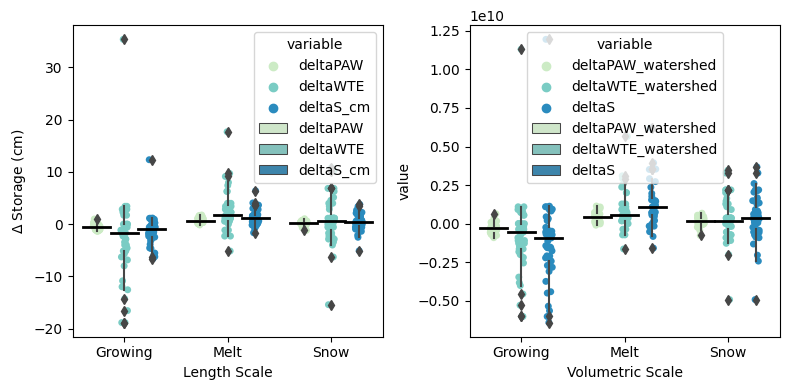

In [ ]:
'''Plot Change in Storage'''
#Subset and melt data for boxplots
storage_seasonal_cm = storage_seasonal[['YEAR', 'Season', 'deltaPAW', 'deltaWTE', 'deltaS_cm']]
storage_seasonal_vol = storage_seasonal[['YEAR', 'Season', 'deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS']]

storage_seasonal_cm = storage_seasonal_cm.melt(id_vars = ['YEAR', 'Season'], value_vars = ['deltaPAW', 'deltaWTE', 'deltaS_cm'])
storage_seasonal_vol = storage_seasonal_vol.melt(id_vars = ['YEAR', 'Season'], value_vars = ['deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS'])

'''Plot Change in Storage'''
fig, [ax, ax1] = plt.subplots(1, 2, figsize = (8, 4), 
                                   sharex = True, 
                                   layout = 'tight')

sns.stripplot(data = storage_seasonal_cm, x = 'Season', y = 'value', hue = 'variable',
            dodge = True, 
            palette = 'GnBu',
            zorder = 0, ax = ax)
sns.boxplot(data = storage_seasonal_cm,  x = 'Season', y = 'value', hue = 'variable',
            showbox = False, showcaps = False, dodge = True,
            palette = 'GnBu',
            medianprops={"color": "k", "linewidth": 2}, 
            ax = ax, zorder = 1)

sns.stripplot(data = storage_seasonal_vol, x = 'Season', y = 'value', hue = 'variable',
            dodge = True,
            palette = 'GnBu',
            zorder = 0, ax = ax1)
sns.boxplot(data = storage_seasonal_vol,  x = 'Season', y = 'value', hue = 'variable',
            showbox = False, showcaps = False, 
            dodge = True,
            palette = 'GnBu',
            medianprops={"color": "k", "linewidth": 2}, 
            ax = ax1, zorder = 1)

ax.set_ylabel(r'$\Delta$ Storage (cm)')
ax.set_xlabel('Length Scale')
ax1.set_xlabel('Volumetric Scale')

In [ ]:
#Merge with frost quantiles for plotting
data_merged_frost = storage_seasonal.merge(upFrostAnnual, left_on = 'YEAR', right_on = 'year', how = 'outer')
#Remove nan rows
data_merged_frost = data_merged_frost.dropna()
#rename columns
data_merged_frost = data_merged_frost.rename(columns = {'S21':'S21_FDpth', 'S22':'S22_FDpth', 'S23':'S23_FDpth'})
#frost quants
data_merged_frost['frostQuant'] = pd.qcut(data_merged_frost['courseMean'], 3, labels = ['Low', 'Med', 'High'])


In [ ]:
#Subset and melt data for boxplots
storage_seasonal_binned_cm = data_merged_frost[['YEAR', 'Season', 'frostQuant', 'deltaPAW', 'deltaWTE', 'deltaS_cm']]
storage_seasonal_binned_vol = data_merged_frost[['YEAR', 'Season', 'frostQuant', 'deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS']]

storage_seasonal_binned_cm = storage_seasonal_binned_cm.melt(id_vars = ['YEAR', 'frostQuant', 'Season'], value_vars = ['deltaPAW', 'deltaWTE', 'deltaS_cm'])
storage_seasonal_binned_vol = storage_seasonal_binned_vol.melt(id_vars = ['YEAR', 'frostQuant', 'Season'], value_vars = ['deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS'])

storage_seasonal_binned_vol.head()

,YEAR,frostQuant,Season,variable,value
0,1968.0,High,Growing,deltaPAW_watershed,-144937000.0
1,1968.0,High,Melt,deltaPAW_watershed,545758200.0
2,1969.0,Low,Growing,deltaPAW_watershed,-566560800.0
3,1969.0,Low,Melt,deltaPAW_watershed,165739600.0
4,1969.0,Low,Snow,deltaPAW_watershed,359946600.0


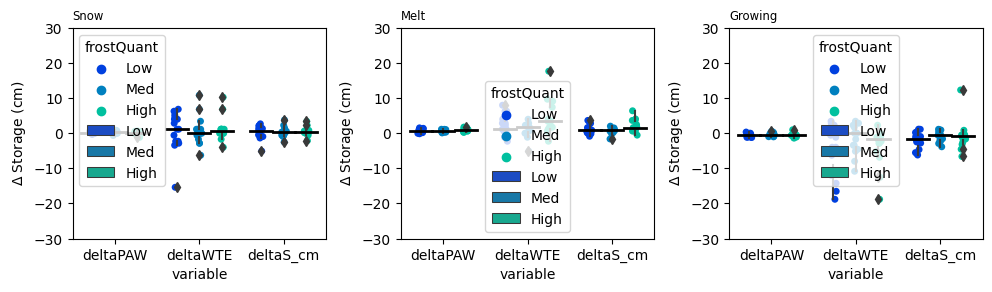

In [ ]:
#Change in storage by snow regime
fig, axs = plt.subplots(1, 3, figsize = (10, 3), 
                                   sharex = True, 
                                   layout = 'tight')

def plotSeasonalStorage(dat, ax, label, length = False):
    sns.stripplot(data = dat, x = 'variable', y = 'value', hue = 'frostQuant',
                dodge = True, hue_order = ['Low', 'Med', 'High'],
                palette = 'winter',
                zorder = 0, ax = ax)
    sns.boxplot(data = dat,  x = 'variable', y = 'value', hue = 'frostQuant',
                showbox = False, showcaps = False, dodge = True, hue_order = ['Low', 'Med', 'High'],
                palette = 'winter',
                medianprops={"color": "k", "linewidth": 2}, 
                ax = ax, zorder = 1)
    ax.set_ylabel(r'$\Delta$ Storage (cm)')
    ax.set_title(label, loc = 'left', fontsize = 'small')

    if(length):
        ax.set_ylim(-30, 30)
    #else:
        #ax.set_ylim(-1e10, 1e10)

ax_array = axs.ravel()
ax_ind = 0
for season in ['Snow', 'Melt', 'Growing']:
    plotSeasonalStorage(storage_seasonal_binned_cm[storage_seasonal_binned_cm.Season == season], 
        ax_array[ax_ind], 
        label = season, 
        length = True)
    
    ax_ind = ax_ind + 1

plt.savefig(save_path + 'storage-analysis-frost.pdf', bbox_inches = 'tight')
plt.savefig(save_path + 'storage-analysis-frost.jpeg', bbox_inches = 'tight')